# EMO1 - series areales
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 16-09-2023*<br>

**Introducción:**<br>
En este _notebook_ se calculan las series meteorológicas areales de las cuencas de CAMELS-ES a partir de los datos meteorológicos de EMO1, los datos de entrada del sistema EFASv5. 

Las series meteorológicas generadas serán los datos dinámicos de entrada para el LSTM que replique el modelo hidrológico LISFLOOD, el usado en EFASv5.

**Por hacer:**<br>
* [x] Las series empiezan el 1 de enero de 1990 y terminan el 1 de enero del 2020. Deberían empezar el 1 de octubre de 2021 y terminar el 30 de septiembre de 2020.

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm.notebook import tqdm
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cf
import yaml
from pathlib import Path

from funciones import polygon_statistics, read_static_map

## Configuración

In [3]:
with open('config.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos del Anurio de Aforos
path_efas = Path(cfg['rutas']['EFAS']['orig'])
path_camels = Path(cfg['rutas']['CAMELS'].get('repo', '../../data/CAMELS-ES'))
path_in = Path(cfg['rutas']['EMO']['orig'])
path_out = Path(cfg['rutas']['EMO']['repo'])
if path_out.exists() is False:
    path_out.mkdir()


# inicio y fin del periodo de estudio
cfg_camels = cfg['CAMELS-ES']
start = cfg_camels['periodo'].get('inicio', None)
end = cfg_camels['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

# sistema de referencia de coordenadas de todos los datos
crs = cfg.get('crs', 4326)

## Cuencas

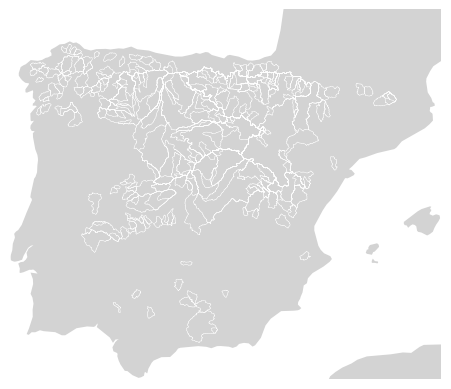

In [4]:
# cargar cuencas
file = glob.glob(str(path_camels / 'shapefiles' / 'catchments*.shp'))[0]
cuencas = gpd.read_file(file)
cuencas.set_index('gauge_id', drop=False, inplace=True)

# plot cuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
cuencas.plot(ax=ax, facecolor='none', edgecolor='w', linewidth=0.3);
ax.axis('off');

## Mapas

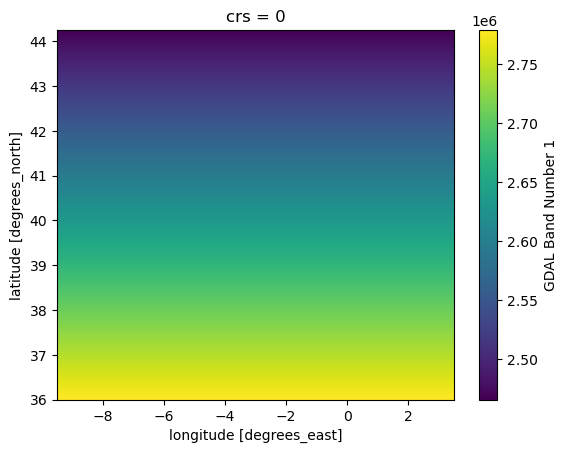

In [5]:
# cargar area de los pixels
pixarea = read_static_map(f'{path_efas}/maps/pixarea*.nc', crs=crs)
pixarea.plot();

## Meteo

En esta sección se cargan la serie temporal de mapas de las variables meteorológicas (`pr`, precipitación; `ta`, temperatura; `e0`, evapotranspiración de referencia). 

La función `polygon_statistics` recorta iterativamente el conjunto de mapas por el polígono de cada cuenca y calcula la media ponderada por el área de cada pixel del mapa.

In [ ]:
# cargar vagamente todos los datos meteorológicos
meteo = {var: xr.open_mfdataset(f'{path_in}/{var}/EMO*{var}*.nc', chunks='auto')[var] for var in ['pr', 'ta', 'e0']}
meteo = xr.Dataset(meteo)
# recortar al periodo de estudio
meteo = meteo.sel(time=slice(start, end))
# definir dimensiones con las coordenadas
meteo = meteo.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
# definir sistema de coordenadas
meteo = meteo.rio.write_crs(crs)

# convertir en volumen
# if var in ['pr', 'e0']:
#     da = da * area * 1e-3

# calcular medias areales
meteo_areal = polygon_statistics(meteo, cuencas, func='mean', ponderacion=pixarea)
meteo_areal = meteo_areal.rename_vars({'pr_mean': 'pr_emo1', 'ta_mean': 'ta_emo1', 'e0_mean': 'e0_emo1'})
del meteo

  0%|          | 0/269 [00:00<?, ?it/s]

C:\ProgramFiles\Anaconda3\envs\tfm\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\ProgramFiles\Anaconda3\envs\tfm\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\ProgramFiles\Anaconda3\envs\tfm\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, a

In [ ]:
# exportar series areales
for id in tqdm(meteo_areal.id.data):
    meteo_areal.sel(id=id).to_netcdf(path_out / f'{id:04}.nc')